In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import time
from collections import deque, namedtuple

import gymnasium as gym
import numpy as np
import PIL.Image
import tensorflow as tf
import utils


from pyvirtualdisplay import Display

from tensorflow.keras import Sequential


from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

# Suppress warnings from imageio
import imageio, logging
logging.getLogger().setLevel(logging.ERROR)
tf.random.set_seed(utils.SEED)

2023-08-15 02:24:48.724513: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9498] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-08-15 02:24:48.724565: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-08-15 02:24:48.724582: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-15 02:24:48.729286: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


2023-08-15 02:24:49.360276: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


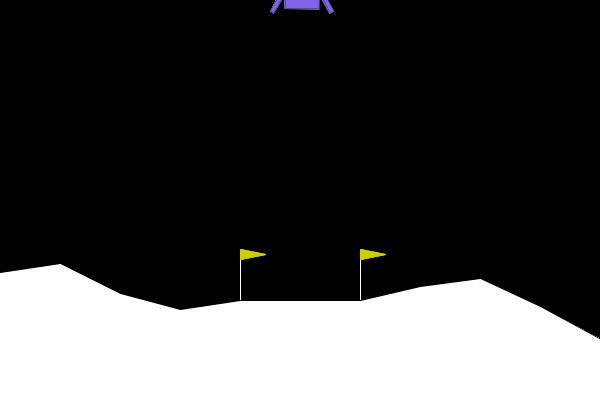

In [3]:
env = gym.make('LunarLander-v2', render_mode ='rgb_array')
current_state = env.reset()
PIL.Image.fromarray(env.render())

In [4]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (8,)
Number of actions: 4


In [5]:
env.reset()

(array([ 0.00352249,  1.411418  ,  0.35678068,  0.022116  , -0.00407495,
        -0.08081619,  0.        ,  0.        ], dtype=float32),
 {})

(array([ 0.00713453,  1.4113284 ,  0.36752203, -0.00400745, -0.01031999,
       -0.12491225,  0.        ,  0.        ], dtype=float32), -1.6547526632278664, False, False, {})


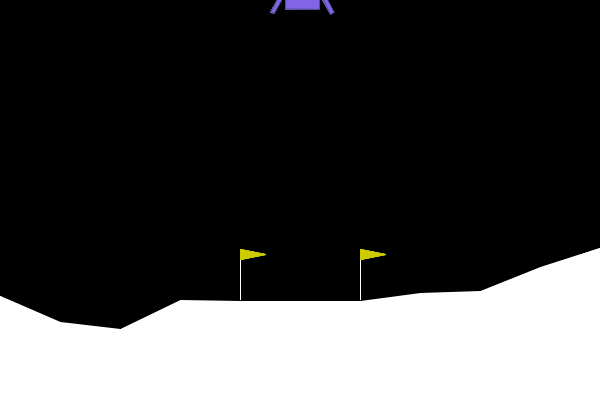

In [6]:
print(env.step(3))
PIL.Image.fromarray(env.render())

In [7]:
current_state = env.reset()

In [8]:
# Select an action
action = 0

# Run a single time step of the environment's dynamics with the given action.
next_state, reward, done, _ , _ = env.step(action)

# Replace the `current_state` with the state after the action is taken
current_state = next_state

In [9]:
GAMMA = 0.995             # discount factor
ALPHA = 1e-3              # learning rate  
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps

In [10]:

# Create the Q-Network
q_network = Sequential([
    ### START CODE HERE ### 
    Input(shape = state_size),
    Dense(activation = 'relu', units = 64),
    Dense(activation = 'relu', units = 64),
    Dense(units = num_actions),
    ### END CODE HERE ### 
    ])

# Create the target Q^-Network
target_q_network = Sequential([
    ### START CODE HERE ### 
    Input(shape = state_size),
    Dense(activation = 'relu', units = 64),
    Dense(activation = 'relu', units = 64),
    Dense(units = num_actions),    
    ### END CODE HERE ###
    ])

### START CODE HERE ### 
optimizer = tf.keras.optimizers.Adam(ALPHA)
### END CODE HERE ###

2023-08-15 02:24:50.737345: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:275] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [11]:
# Store experiences as named tuples
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [12]:
def compute_loss(experiences, gamma, q_network, target_q_network):
    """ 
    Calculates the loss.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
      q_network: (tf.keras.Sequential) Keras model for predicting the q_values
      target_q_network: (tf.keras.Sequential) Keras model for predicting the targets
          
    Returns:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) the Mean-Squared Error between
            the y targets and the Q(s,a) values.
    """

    # Unpack the mini-batch of experience tuples
    states, actions, rewards, next_states, done_vals = experiences
    
    # Compute max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)
    
    # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a).
    ### START CODE HERE ### 
    
    y_targets = rewards +( gamma * max_qsa) * (1-done_vals)
    ### END CODE HERE ###
    
    # Get the q_values and reshape to match y_targets
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))
        
    # Compute the loss
    ### START CODE HERE ### 
    loss = MSE(y_targets, q_values)
    ### END CODE HERE ### 
    
    return loss

In [13]:
@tf.function
def agent_learn(experiences, gamma):
    """
    Updates the weights of the Q networks.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
    
    """
    
    # Calculate the loss
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Get the gradients of the loss with respect to the weights.
    gradients = tape.gradient(loss, q_network.trainable_variables)
    
    # Update the weights of the q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # update the weights of target q_network
    utils.update_target_network(q_network, target_q_network)

In [14]:
env.reset()[0]

array([-0.00448236,  1.4215995 , -0.45403147,  0.47462904,  0.00520071,
        0.10284481,  0.        ,  0.        ], dtype=float32)

In [15]:
start = time.time()

num_episodes = 2000
max_num_timesteps = 1000

total_point_history = []

num_p_av = 100    # number of total points to use for averaging
epsilon = 1.0     # initial ε value for ε-greedy policy

# Create a memory buffer D with capacity N
memory_buffer = deque()

# Set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):
    
    # Reset the environment to the initial state and get the initial state
    state = env.reset()[0]
    total_points = 0
    
    for t in range(max_num_timesteps):
        
        # From the current state S choose an action A using an ε-greedy policy
        state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network
        q_values = q_network(state_qn)
        action = utils.get_action(q_values, epsilon)
        
        # Take action A and receive reward R and the next state S'
        next_state, reward, done, _ = env.step(action)[:4]
        
        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(experience(state, action, reward, next_state, done))
        
        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        update = utils.check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
        
        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = utils.get_experiences(memory_buffer)
            
            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            agent_learn(experiences, GAMMA)
        
        state = next_state.copy()
        total_points += reward
        
        if done:
            break
            
    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])
    
    # Update the ε value
    epsilon = utils.get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if av_latest_points >= 200.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('lunar_lander_model.h5')
        break
        
tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 100 | Total point average of the last 100 episodes: -147.92
Episode 200 | Total point average of the last 100 episodes: -86.665
Episode 300 | Total point average of the last 100 episodes: -40.89
Episode 400 | Total point average of the last 100 episodes: -16.31
Episode 500 | Total point average of the last 100 episodes: 80.851
Episode 592 | Total point average of the last 100 episodes: 200.08

Environment solved in 592 episodes!

Total Runtime: 794.10 s (13.23 min)


/home/hhdtan/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
filename = "./lunar.mp4"
utils.create_video(filename, env, q_network)
utils.embed_mp4(filename)   

[swscaler @ 0x595e000] Warning: data is not aligned! This can lead to a speed loss
